In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as log_progress
from ipywidgets import widgets # for buttons and dropdown menus
from IPython.display import display, clear_output # for buttons and dropdown menus
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scalecast import GridGenerator
from scalecast.Forecaster import Forecaster
from scalecast.Forecaster import _determine_best_by_

In [2]:
models = ('knn','svr','elasticnet','mlp','gbt','prophet')
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
GridGenerator.get_example_grids()

In [4]:
def find_integration(f):
    """ uses augmented dickey fuller to guess that series is stationary at 0, 1, or 2 differences
    """
    if f.adf_test():
        return 0
    f.diff()
    if f.adf_test():
        f.undiff()
        return 1
    f.undiff()
    return 2

def results_vis(f_dict,plot_type='forecast'):
    """ visualize the forecast results
        leverages Jupyter widgets
    """
    def display_user_selections(ts_selection,mo_selection,lv_selection,me_selection):
        matplotlib.use('nbAgg')
        %matplotlib inline
        sns.set(rc={'figure.figsize':(16,8)})
        selected_data = f_dict[ts_selection]
        if plot_type == 'forecast':
            print(ts_selection)
            selected_data.plot(models=f'top_{mo_selection}',order_by=me_selection,level=lv_selection,
                               print_attr=['TestSetRMSE','TestSetR2','LevelTestSetRMSE','TestSetMAPE','LevelTestSetR2',
                                           'LevelTestSetMAPE','Scaler','HyperParams','Xvars','models','Integration'])
        elif plot_type == 'test':
            print(ts_selection)
            selected_data.plot_test_set(models=f'top_{mo_selection}',order_by=me_selection,include_train=52,level=lv_selection)

    def on_button_clicked(b):
        mo_selection = mo_dd.value
        ts_selection = ts_dd.value
        lv_selection = lv_dd.value
        me_selection = me_dd.value
        with output:
            clear_output()
            display_user_selections(ts_selection,mo_selection,lv_selection,me_selection)
    
    all_models = models + ('weighted','avg')
    ts_dd = widgets.Dropdown(options=f_dict.keys(), description = 'Time Series:')
    mo_dd = widgets.Dropdown(options=range(1,len(all_models)+1), description = 'No. Models')
    lv_dd = widgets.Dropdown(options=[True,False],description='View Level')
    me_dd = widgets.Dropdown(options=sorted([e for e in _determine_best_by_ if e is not None]),description='Order By')

    # never changes
    button = widgets.Button(description="Select Time Series")
    output = widgets.Output()

    display(ts_dd,mo_dd,lv_dd,me_dd)
    display(button, output)
    
    button.on_click(on_button_clicked)

In [5]:
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv',dtype={'RegionName':str}).set_index('RegionName')

In [6]:
df.head()

,RegionID,SizeRank,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
RegionName,,,,,,,,,,,,,,,,,,,,,
10025,61639,0,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,190326.0,189141.0,...,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0,1040011.0,1053436.0,1071606.0,1089141.0
60657,84654,1,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,265417.0,264722.0,...,498313.0,501107.0,503788.0,506264.0,508612.0,510663.0,512798.0,514068.0,515876.0,517752.0
10023,61637,2,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,264983.0,265039.0,...,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0,1097381.0,1096338.0,1100727.0,1104368.0
77494,91982,3,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,202246.0,202496.0,...,343597.0,345154.0,347658.0,350766.0,355204.0,359560.0,364683.0,370188.0,376591.0,383493.0
60614,84616,4,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,358228.0,357217.0,...,639022.0,641924.0,644626.0,647452.0,650068.0,652220.0,654997.0,656960.0,659558.0,661174.0


In [7]:
zips = open('./zips.txt','r').read().split('\n')
zips

['84009', '84095', '34746', '32303', '30328']

In [8]:
preds = {}
for z in zips:
    data_load = df.loc[z].transpose()
    f = Forecaster(y=data_load.values[8:],current_dates=data_load.index[8:],name=z)
    preds[str(z)] = f

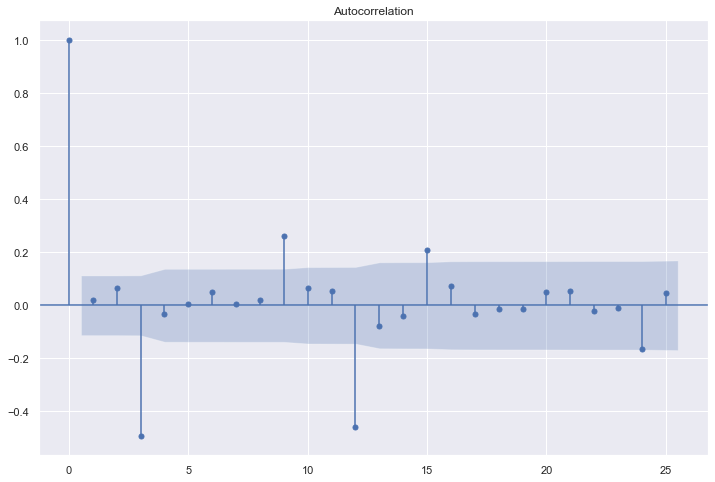

In [9]:
f.plot_acf(diffy=2)
plt.show()

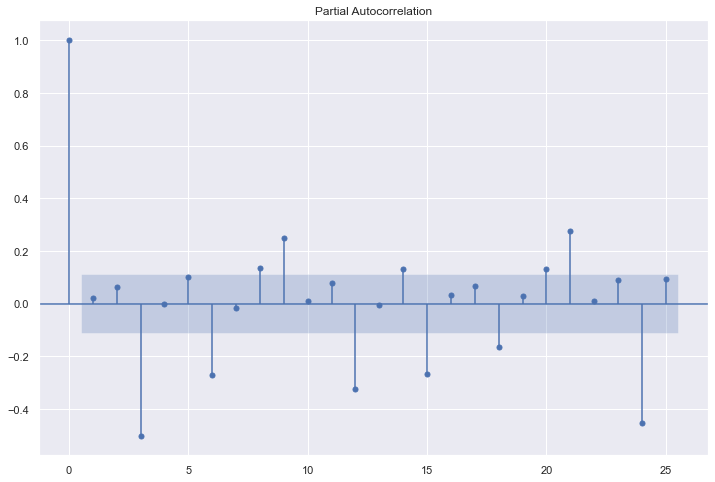

In [10]:
f.plot_pacf(diffy=2)
plt.show()

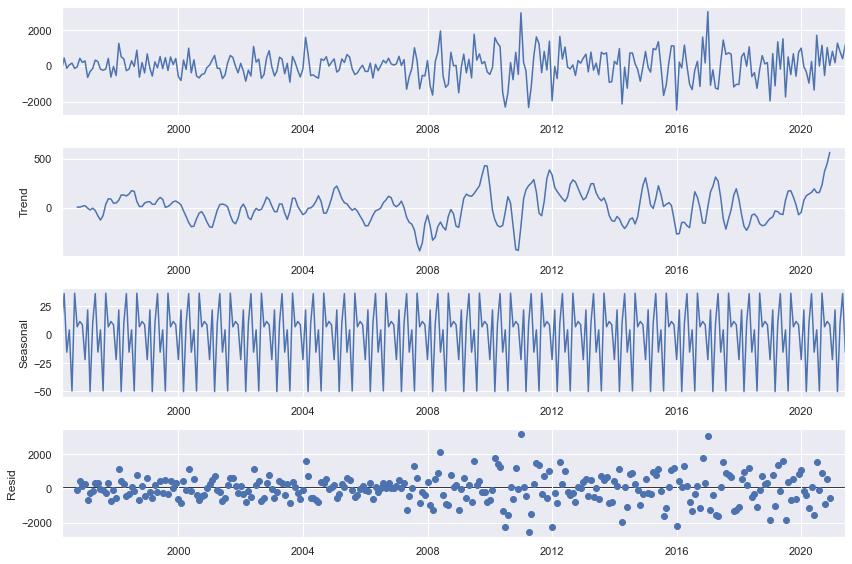

In [11]:
f.seasonal_decompose(diffy=2).plot()
plt.show()

In [ ]:
for k, f in log_progress(preds.items()):
    print(k)
    i = find_integration(f)
    f.generate_future_dates(12)
    f.set_test_length(9)
    f.set_validation_length(6)
    f.add_ar_terms(3)
    f.add_AR_terms((4,3))
    f.add_AR_terms((2,12))
    f.diff(i)
    f.add_seasonal_regressors('quarter',raw=False,dummy=True)
    f.add_seasonal_regressors('month',raw=False,dummy=True)
    f.add_seasonal_regressors('year')
    f.add_covid19_regressor(called='COVID19',end='2021-12-01')
    f.add_other_regressor(called='2008_recession',start='2007-10-01',end='2009-06-30')
    f.add_time_trend(called='t')
    f.add_combo_regressors('t','COVID19',sep='_')
    f.add_poly_terms('t_COVID19')
    
    for m in log_progress(models):
        f.set_estimator(m)
        f.tune()
        f.auto_forecast()
        
    f.set_estimator('combo')
    f.manual_forecast(how='simple',models='top_3',call_me='avg')
    f.manual_forecast(how='weighted',models='top_5',call_me='weighted')

  0%|          | 0/5 [00:00<?, ?it/s]

84009


  0%|          | 0/6 [00:00<?, ?it/s]

84095


  0%|          | 0/6 [00:00<?, ?it/s]

34746


  0%|          | 0/6 [00:00<?, ?it/s]

32303


  0%|          | 0/6 [00:00<?, ?it/s]

30328


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
model_summaries = pd.DataFrame()
for k, f in preds.items():
    df = f.export(dfs='model_summaries',determine_best_by='LevelTestSetMAPE')
    df['Name'] = k
    model_summaries = pd.concat([model_summaries,df],ignore_index=True)
    
model_summaries.to_csv('model_summaries.csv',index=False)

In [ ]:
results_vis(preds,'forecast')

In [ ]:
results_vis(preds,'test')